#**Maestría en Inteligencia Artificial Aplicada**
## TC5035.10
##**Curso: Proyecto Integrador**
###Tecnológico de Monterrey

---

**Docente Titular**: Dra. Grettel Barceló Alonso y Dr. Luis Eduardo Falcón

**Docente Asistente**: Veronica Guzman del Valle

**Docente Tutor**: Eduviges Ludivina Facundo Flores

**Docente del ITCJ Responsable**: Mtra. Yadira Dozal Assmar

#**Nombre del Proyecto:**
---
*"Modelado de serie de tiempo para pronosticar la demanda de prórrogas de licenciatura en ITCJ"*

---

#**Integrantes Equipo #13:**
* A01796362 Eduardo Perez Carrillo
* A01795907 Nancy Teresa Zapien García
* A01796060 Hugo Alberto Cuevas García

#**Avance 1. ANALISIS EXPLORATORIO DE DATOS (EDA)**

In [1]:
# =========================
# LIBRERÍAS BASE
# =========================
import pandas as pd              # Manipulación y análisis de datos (DataFrames)
import numpy as np               # Operaciones numéricas (vectores, arrays, etc.)
import matplotlib.pyplot as plt  # Visualización (gráficas)
import os
from google.colab import drive

In [2]:
# =========================
# 1) CARGA DEL DATASET (CSV)
# =========================
# Ruta / nombre del archivo CSV exportado desde Excel.
# Nota: cuando se exporta desde Excel en ambientes Windows en español,
# suele guardarse con codificación Latin-1 (ISO-8859-1) o cp1252, no UTF-8.
path = "dataset.csv"

# Lectura del CSV:
# - encoding="latin1" evita errores de decodificación (UnicodeDecodeError) al contener acentos y caracteres especiales.
# - Si en otro equipo falla, alternativa típica: encoding="cp1252".
df = pd.read_csv(path, encoding="latin1")


In [3]:
# =========================
# 2) VALIDACIÓN RÁPIDA DE CARGA
# =========================
print("---------------------------")
# Shape: (filas, columnas). Sirve para verificar que coincida con el tamaño esperado del dataset.
print("Shape:", df.shape)

print("---------------------------")
# Vista rápida de las primeras filas: ayuda a confirmar estructura, valores y nombres de columnas.
display(df.head())

print("---------------------------")
# Tipos de datos detectados por pandas. Aquí es normal ver:
# - 'object' para texto y fechas cuando vienen como strings.
# Más adelante convertiremos las fechas a datetime.
print(df.dtypes)


---------------------------
Shape: (1765, 6)
---------------------------


,aprobado,carrera,periodo_solicitud,periodo_inicio,num_semestres_aprobados,semestre_actual
0,si,Licenciatura Administración,01/07/2019,01/01/2020,7,11
1,si,Ingeniería Industria EAD,01/07/2019,01/01/2020,4,12
2,si,Ingeniería Industrial,01/07/2019,01/01/2020,13,6
3,si,Licenciatura Administración,01/07/2019,01/01/2020,11,7
4,si,Licenciatura Administración,01/07/2019,01/01/2020,8,8


---------------------------
aprobado                   object
carrera                    object
periodo_solicitud          object
periodo_inicio             object
num_semestres_aprobados     int64
semestre_actual             int64
dtype: object


## **ANÁLISIS DE DATOS FALTANTES (EDA)**

En este bloque se revisa la calidad del dataset,
identificando valores faltantes (NaN) por columna.

Este paso es fundamental antes de cualquier transformación o modelado, ya que valores faltantes pueden sesgar resultados.

In [4]:
missing_summary = (
    df.isna()
      .sum()
      .to_frame(name="n_missing")
      .assign(pct_missing=lambda x: 100 * x["n_missing"] / len(df))
)

display(missing_summary)

,n_missing,pct_missing
aprobado,0,0.0
carrera,0,0.0
periodo_solicitud,0,0.0
periodo_inicio,0,0.0
num_semestres_aprobados,0,0.0
semestre_actual,0,0.0


Se revisa la presencia de valores faltantes en las columnas críticas del análisis. Este paso se realiza después de normalizar los nombres de las columnas.

In [5]:
print("Columnas disponibles en el dataset:")
print(df.columns.tolist())

# Columnas críticas esperadas
expected_critical_cols = [
    "aprobado",
    "carrera",
    "periodo_solicitud",
    "periodo_inicio",
    "num_semestres_aprobados",
    "semestre_actual"
]

# Mantener solo las columnas que realmente existen
critical_cols = [c for c in expected_critical_cols if c in df.columns]

print("\nColumnas críticas encontradas:")
print(critical_cols)

# Revisión de valores nulos
missing_critical = (
    df[critical_cols]
    .isna()
    .sum()
    .to_frame(name="n_missing")
)

display(missing_critical)

Columnas disponibles en el dataset:
['aprobado', 'carrera', 'periodo_solicitud', 'periodo_inicio', 'num_semestres_aprobados', 'semestre_actual']

Columnas críticas encontradas:
['aprobado', 'carrera', 'periodo_solicitud', 'periodo_inicio', 'num_semestres_aprobados', 'semestre_actual']


,n_missing
aprobado,0
carrera,0
periodo_solicitud,0
periodo_inicio,0
num_semestres_aprobados,0
semestre_actual,0


In [6]:
# Revisión de strings vacíos o solo espacios
empty_strings = (
    df[critical_cols]
    .astype(str)
    .apply(lambda col: col.str.strip().eq("").sum())
)

empty_strings


,0
aprobado,0
carrera,0
periodo_solicitud,0
periodo_inicio,0
num_semestres_aprobados,0
semestre_actual,0



## **NORMALIZACIÓN DE NOMBRES DE COLUMNAS**


Estandarizamos los nombres de las columnas:
 - strip(): elimina espacios en blanco al inicio y final
 - lower(): convierte todo a minúsculas

Esto es una buena práctica porque:
 1) Evita errores por diferencias de mayúsculas/minúsculas.
 2) Facilita la escritura de código reproducible.
 3) Permite mantener consistencia en todo el pipeline.

In [7]:
df.columns = [c.strip().lower() for c in df.columns]

# Imprimimos la lista de columnas para verificar el resultado
print(df.columns.tolist())


['aprobado', 'carrera', 'periodo_solicitud', 'periodo_inicio', 'num_semestres_aprobados', 'semestre_actual']



## **NORMALIZACIÓN DE LA VARIABLE OBJETIVO (APROBADO)**

El objetivo es convertir la variable categórica "aprobado"

en una variable binaria numérica:

   1 -> solicitud aprobada
   
   0 -> solicitud no aprobada

Esto es necesario porque:
 - Los modelos de machine learning y series temporales
   trabajan con variables numéricas.
 - Facilita conteos, agregaciones y métricas.
 - Evita ambigüedades por diferentes formas de escritura.

In [8]:
df["aprobado_norm"] = (
    df["aprobado"]
    # Convertimos a string para evitar problemas si hay valores nulos o mixtos
    .astype(str)
    # Eliminamos espacios en blanco
    .str.strip()
    # Convertimos a minúsculas para estandarizar
    .str.lower()
    # Normalizamos variaciones comunes del "sí"
    .replace({"sí": "si"})
    # Mapeo final a binario:
    # valores considerados como aprobación -> 1
    # cualquier otro valor -> 0
    .map(lambda x: 1 if x in ["si", "1", "true", "aprobado", "yes", "y"] else 0)
)

# =========================
# VERIFICACIÓN DE RESULTADOS
# =========================
# Distribución original de la variable categórica
print("Valores originales:")
print(df["aprobado"].value_counts())

# Distribución de la variable binaria normalizada
print("\nValores normalizados:")
print(df["aprobado_norm"].value_counts())


Valores originales:
aprobado
Si    1136
si     484
No     112
no      33
Name: count, dtype: int64

Valores normalizados:
aprobado_norm
1    1620
0     145
Name: count, dtype: int64



## **EXPLORACIÓN DE LA VARIABLE "CARRERA"**

En esta etapa realizamos una exploración básica de la variable categórica "carrera"

 con el objetivo de:
  1) Conocer cuántas carreras distintas existen en el dataset.
 2) Identificar las carreras con mayor número de solicitudes.
 3) Detectar posibles categorías dominantes o poco representadas.


In [9]:
# Número total de carreras únicas
print("Número de carreras únicas:", df["carrera"].nunique())

# Frecuencia de solicitudes por carrera
# Se muestran solo las 15 carreras con mayor número de registros
df["carrera"].value_counts().head(15)

Número de carreras únicas: 15


,count
carrera,
Ingeniería Industrial,325
Licenciatura Administración,321
Contador Público,207
Ingeniería Mecatrónica,181
Ingeniería Logística,173
Ingeniería Gestión Empresarial,161
Ingeniería Sistemas Computacionales,140
Ingeniería Electromecanica,86
Ingeniería Mecánica,41



## **NORMALIZACIÓN Y AGRUPACIÓN DE LA VARIABLE "CARRERA"**

En este paso se crea una versión normalizada de la variable "carrera" con el objetivo de reducir la cardinalidad de categorías y facilitar el análisis agregado.

Específicamente, todas las carreras que pertenecen a la modalidad de Educación a Distancia (EAD) se agrupan en una sola categoría: "EAD".


In [10]:
# Crear una copia normalizada de la carrera:
# - astype(str): asegura compatibilidad aunque existan valores nulos
# - strip(): elimina espacios en blanco al inicio y final
df["carrera_norm"] = df["carrera"].astype(str).str.strip()

# Agrupar todas las carreras cuya descripción termina en "EAD"
# - str.upper(): evita problemas por mayúsculas/minúsculas
# - str.endswith("EAD"): identifica la modalidad EAD
#
# Todas estas observaciones se asignan a la categoría única "EAD"
df.loc[
    df["carrera_norm"].str.upper().str.endswith("EAD"),
    "carrera_norm"
] = "EAD"

# =========================
# VERIFICACIÓN DE RESULTADOS
# =========================
# Distribución original de carreras (top 15)
print("Carreras originales (top 15):")
print(df["carrera"].value_counts().head(15))

# Distribución después de la normalización (top 15)
print("\nCarreras normalizadas (top 15):")
print(df["carrera_norm"].value_counts().head(15))



Carreras originales (top 15):
carrera
Ingeniería Industrial                                        325
Licenciatura Administración                                  321
Contador Público                                             207
Ingeniería Mecatrónica                                       181
Ingeniería Logística                                         173
Ingeniería Gestión Empresarial                               161
Ingeniería Sistemas Computacionales                          140
Ingeniería Electromecanica                                    86
Ingeniería Mecánica                                           41
Ingeniería Eléctrica                                          38
Ingeniería Industria EAD                                      33
Ingeniería Electrónica                                        25
Ingeniería Tecnologías de la Información y Comunicaciones     22
Ingeniería Gestión Empresarial EAD                            10
Ingeniería Sistemas Computacionales EAD             

In [11]:
def parse_and_fix_semester_dates(s: pd.Series) -> pd.Series:
    """
    Convierte una serie de fechas a formato datetime semestral.

    La función:
    - Maneja ambigüedad entre formatos dd/mm/yyyy y mm/dd/yyyy.
    - Identifica automáticamente el parseo más coherente.
    - Colapsa todas las fechas a un esquema semestral:
        * Enero (S1)
        * Julio (S2)

    Parámetros
    ----------
    s : pd.Series
        Serie de fechas en formato texto.

    Retorna
    -------
    pd.Series
        Serie de fechas normalizadas a formato datetime,
        usando únicamente enero o julio como meses válidos.
    """

    # =========================
    # 1) PARSEO DE FECHAS CON AMBIGÜEDAD
    # =========================
    # Intento 1: interpretar la fecha como día/mes/año (formato común en LATAM)
    dt1 = pd.to_datetime(s, errors="coerce", dayfirst=True)

    # Intento 2: interpretar la fecha como mes/día/año (formato común en sistemas anglosajones)
    dt2 = pd.to_datetime(s, errors="coerce", dayfirst=False)

    # =========================
    # 2) SELECCIÓN DEL PARSEO MÁS COHERENTE
    # =========================
    # Extraemos los meses resultantes de cada intento
    m1 = dt1.dt.month
    m2 = dt2.dt.month

    # Regla de decisión:
    # - Si el primer intento (dt1) NO cae en un mes semestral válido (enero o julio)
    # - PERO el segundo intento (dt2) SÍ cae en enero o julio
    # entonces asumimos que el formato correcto era mm/dd/yyyy
    use_dt2 = (~m1.isin([1, 7])) & (m2.isin([1, 7]))

    # Inicialmente usamos el primer parseo
    dt = dt1.copy()

    # Sustituimos por el segundo parseo solo donde sea más consistente
    dt[use_dt2] = dt2[use_dt2]

    # =========================
    # 3) COLAPSO A FECHAS SEMESTRALES
    # =========================
    # Regla semestral:
    # - Mes <= 6  -> Primer semestre (enero)
    # - Mes > 6   -> Segundo semestre (julio)
    fixed_month = np.where(dt.dt.month <= 6, 1, 7)

    # Construimos una nueva fecha usando:
    # - Año original
    # - Mes semestral (1 o 7)
    # - Día fijo = 1
    dt_fixed = pd.to_datetime(
        dict(year=dt.dt.year, month=fixed_month, day=1),
        errors="coerce"
    )

    return dt_fixed



## **PARSEO Y NORMALIZACIÓN DE FECHAS A FORMATO SEMESTRAL**

 Aplicamos la función parse_and_fix_semester_dates() a las dos columnas temporales clave:
 - periodo_solicitud: semestre en el que el alumno realizó formalmente la solicitud.
 - periodo_inicio: semestre en el que el alumno desea comenzar a utilizar la prórroga.

 Ambas se convierten a datetime y se colapsan a una fecha representativa semestral:
 - 01/01/YYYY  ->  YYYY-S1
 - 01/07/YYYY  ->  YYYY-S2

In [12]:
# Esto estandariza el eje temporal para agregaciones y modelado de series.

df["periodo_solicitud_dt"] = parse_and_fix_semester_dates(df["periodo_solicitud"])
df["periodo_inicio_dt"] = parse_and_fix_semester_dates(df["periodo_inicio"])

# =========================
# CONTROL DE CALIDAD: VALORES NULOS
# =========================
# Verificamos cuántas fechas no pudieron ser parseadas (NaT).
# Un número alto aquí indicaría:
# - formatos inválidos,
# - valores faltantes,
# - errores de captura,
# - o inconsistencias que requieren limpieza adicional.
print("Nulos en periodo_solicitud_dt:", df["periodo_solicitud_dt"].isna().sum())
print("Nulos en periodo_inicio_dt:", df["periodo_inicio_dt"].isna().sum())



Nulos en periodo_solicitud_dt: 0
Nulos en periodo_inicio_dt: 0



## **VALIDACIÓN DE CONSISTENCIA SEMESTRAL**

En este paso verificamos explícitamente que las fechas normalizadas
 cumplen con el esquema semestral definido:
   - Enero (mes = 1)  -> Primer semestre (S1)
   - Julio  (mes = 7) -> Segundo semestre (S2)

 No deberían aparecer otros meses (2–6, 8–12).
 Si aparecen, indicaría un error en el parseo o en los datos originales.


In [13]:
print(
    "Meses únicos en periodo_solicitud_dt:",
    sorted(df["periodo_solicitud_dt"].dt.month.unique())
)

print(
    "Meses únicos en periodo_inicio_dt:",
    sorted(df["periodo_inicio_dt"].dt.month.unique())
)

Meses únicos en periodo_solicitud_dt: [np.int32(1), np.int32(7)]
Meses únicos en periodo_inicio_dt: [np.int32(1), np.int32(7)]



## **CREACIÓN DE ETIQUETAS SEMESTRALES (YYYY-S1 / YYYY-S2)**

En este paso construimos etiquetas de semestre en formato:
   "AÑO-S1" para enero (1)
   "AÑO-S2" para julio (7)

Estas etiquetas son útiles para:
 - visualización y análisis exploratorio (EDA)
 - reportes y tablas (más legible que un datetime)
 - validación rápida del alineamiento temporal

Importante: para modelado, seguimos usando datetime/índices numéricos, pero esta columna mejora la interpretabilidad.

In [14]:
def semestre_label(dt):
    """
    Convierte una serie datetime semestral (enero/julio) a una etiqueta tipo 'YYYY-S1' o 'YYYY-S2'.

    Parámetros
    ----------
    dt : pd.Series (datetime64)
        Serie de fechas ya normalizadas a meses 1 (enero) o 7 (julio).

    Retorna
    -------
    pd.Series
        Etiquetas en texto: 'YYYY-S1' / 'YYYY-S2'.
    """
    # Mapear el mes a semestre:
    # - 1 -> S1
    # - 7 -> S2
    semestre = dt.dt.month.map({1: "S1", 7: "S2"})

    # Concatenar año + '-' + semestre
    return dt.dt.year.astype(str) + "-" + semestre


# Crear etiquetas para:
# - Semestre en el que se solicitó formalmente la prórroga
df["semestre_solicitud"] = semestre_label(df["periodo_solicitud_dt"])

# - Semestre en el que se planea utilizar la prórroga
df["semestre_inicio"] = semestre_label(df["periodo_inicio_dt"])


# =========================
# VERIFICACIÓN VISUAL (SANITY CHECK)
# =========================
# Mostramos un subconjunto de columnas para confirmar:
# 1) que las fechas se parsearon correctamente,
# 2) que la etiqueta coincide con el semestre real (enero/julio),
# 3) que no hay desalineaciones evidentes entre texto original y datetime.
df[[
    "periodo_solicitud", "periodo_solicitud_dt", "semestre_solicitud",
    "periodo_inicio", "periodo_inicio_dt", "semestre_inicio"
]].head(10)


,periodo_solicitud,periodo_solicitud_dt,semestre_solicitud,periodo_inicio,periodo_inicio_dt,semestre_inicio
0,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
1,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
2,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
3,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
4,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
5,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
6,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
7,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
8,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
9,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1



## **ORDENAMIENTO TEMPORAL POR SEMESTRE DE SOLICITUD**

Para cualquier análisis de series temporales es indispensable que los datos estén correctamente ordenados en el tiempo.

Aquí ordenamos el dataset usando la fecha datetime semestral asociada al periodo de solicitud de la prórroga.

In [15]:

df = (
    df
    .sort_values("periodo_solicitud_dt")  # orden cronológico
    .reset_index(drop=True)               # reinicio de índice para coherencia
)

# =========================
# VERIFICACIÓN DEL RANGO TEMPORAL
# =========================
# Confirmamos explícitamente cuál es:
# - el primer semestre presente en el dataset
# - el último semestre presente en el dataset
#
# Esta información será clave más adelante para:
# - definir puntos de corte (cutoff) configurables,
# - validar horizontes de pronóstico,
# - justificar el rango temporal analizado.

print("Primer semestre:", df["semestre_solicitud"].iloc[0])
print("Último semestre:", df["semestre_solicitud"].iloc[-1])


Primer semestre: 2019-S2
Último semestre: 2025-S2


In [16]:
# =========================
# PARÁMETRO CONFIGURABLE
# =========================
ULTIMO_SEMESTRE = "2025-S2"   # <-- cambia aquí cuando lo necesites



## **CONVERSIÓN DE SEMESTRE A ÍNDICE TEMPORAL NUMÉRICO**

En series temporales es común trabajar con un índice numérico ordenable
(0, 1, 2, 3, ...) en lugar de etiquetas textuales.

 Aquí convertimos etiquetas del tipo:

   "YYYY-S1"
   "YYYY-S2"

 a un índice entero continuo que respeta el orden temporal.

La regla utilizada es:
  índice = (año * 2) + offset

 donde:
   offset = 0  -> primer semestre (S1)
   offset = 1  -> segundo semestre (S2)

 Ejemplos:
   2023-S1 -> 2023*2 + 0 = 4046
   2023-S2 -> 2023*2 + 1 = 4047
   2024-S1 -> 2024*2 + 0 = 4048

 Este índice:
 - preserva el orden cronológico,
 - permite comparar semestres con operadores numéricos (<, >, <=),
 - facilita la creación de puntos de corte (cutoff),
 - es ideal para validación walk-forward.


In [17]:

def semestre_index(label):
    """
    Convierte una etiqueta semestral 'YYYY-S1' / 'YYYY-S2'
    en un índice temporal entero ordenable.

    Parámetros
    ----------
    label : str
        Etiqueta semestral en formato 'YYYY-S1' o 'YYYY-S2'.

    Retorna
    -------
    int
        Índice temporal numérico que preserva el orden cronológico.
    """
    # Separar la etiqueta en año y semestre
    year, sem = label.split("-")

    # Asignar offset según semestre:
    # S1 -> 0
    # S2 -> 1
    offset = 0 if sem == "S1" else 1

    # Construir el índice final
    return int(year) * 2 + offset


# =========================
# APLICACIÓN DEL ÍNDICE AL DATASET
# =========================
# Creamos una nueva columna con el índice semestral numérico
# que será usada para:
# - filtrar rangos temporales,
# - definir el último semestre considerado (cutoff),
# - validar el orden temporal del dataset.
df["semestre_idx"] = df["semestre_solicitud"].apply(semestre_index)


# =========================
# DEFINICIÓN DEL PUNTO DE CORTE (CUTOFF)
# =========================
# Convertimos el último semestre permitido (configurable)
# al mismo índice numérico para poder compararlo directamente.
#
# Ejemplo:
#   ULTIMO_SEMESTRE = "2025-S2"
#   cutoff_idx = 2025*2 + 1 = 4051
cutoff_idx = semestre_index(ULTIMO_SEMESTRE)

print("Cutoff index:", cutoff_idx)

Cutoff index: 4051



## **APLICACIÓN DEL CUTOFF TEMPORAL (FILTRADO DEL DATASET)**

En este paso se construye el dataset que será utilizado para:
 - análisis exploratorio (EDA),
 - agregaciones temporales,
 - entrenamiento de modelos,
 - validación walk-forward.

Para ello, se aplica un punto de corte temporal (cutoff_idx) que define el último semestre permitido en el análisis.

 Cualquier observación con semestre_idx > cutoff_idx se excluye, garantizando que NO se utilice información futura (data leakage).

In [18]:
df_eda = (
    df[df["semestre_idx"] <= cutoff_idx]
    .copy()   # Se crea una copia explícita para evitar SettingWithCopyWarning
)

# =========================
# VERIFICACIÓN DEL RANGO TEMPORAL INCLUIDO
# =========================
# Mostramos explícitamente qué semestres quedaron dentro del rango analizado.
# Esta salida sirve para:
# - confirmar que el cutoff se aplicó correctamente,
# - documentar el periodo histórico utilizado,
# - detectar exclusiones inesperadas.
print("Semestres incluidos:")
print(sorted(df_eda["semestre_solicitud"].unique()))


Semestres incluidos:
['2019-S2', '2020-S2', '2021-S1', '2021-S2', '2022-S1', '2022-S2', '2023-S1', '2023-S2', '2024-S1', '2024-S2', '2025-S1', '2025-S2']



## **AGREGACIÓN TEMPORAL POR SEMESTRE**

 En este paso se construye la serie temporal agregada a nivel semestral.

 Cada fila del resultado representa un semestre académico (enero o julio),
 y las métricas agregadas describen la demanda y el resultado de las solicitudes
 realizadas en dicho semestre.

Importante:
 - La agregación se hace sobre "periodo_solicitud_dt", es decir,
   el semestre en el que el alumno solicitó formalmente la prórroga.
 - No se utiliza el semestre de inicio, ya que el objetivo es modelar la demanda de solicitudes, no su ejecución futura.

*  Enriquecimiento del Perfil de Demanda (Feature Engineering): La transición de un análisis meramente cuantitativo ("cuántas solicitudes") a uno cualitativo ("quiénes solicitan") es fundamental. Al generar la métrica promedio_semestre_alumno, el modelo no solo detecta volúmenes, sino patrones en el perfil académico de los solicitantes. Esto permite explicar fluctuaciones en la demanda; por ejemplo, si en un periodo específico el perfil del solicitante se concentra en semestres avanzados (ej. 8vo semestre), el sistema puede inferir dinámicas de egreso que impactan la carga institucional.

*  Fundamentación de Métodos de Filtrado (ANOVA y Correlación): La creación de variables agregadas permite la ejecución de métodos de filtrado estadístico para la selección de características. Mediante el análisis de correlación de Pearson o pruebas de ANOVA entre la tasa_aprobacion y el promedio_semestre_alumno, se obtiene una base científica para identificar qué variables tienen una relación significativa con el fenómeno estudiado, cumpliendo con el rigor estadístico solicitado en el marco experimental.

*  Viabilidad de Técnicas de Extracción (Análisis de Componentes Principales - PCA): Al incrementar la dimensionalidad del dataset con variables sintéticas como total_solicitudes, promedio_duracion_prorroga y total_semestres_otorgados, se habilita el uso justificado de técnicas de extracción de características. La aplicación de PCA sobre estas variables escaladas permite reducir la complejidad del modelo y los requerimientos de almacenamiento, eliminando la redundancia informativa y optimizando los tiempos de entrenamiento del modelo de pronóstico final.

In [19]:
agg = (
    df_eda
    .groupby("periodo_solicitud_dt")
    .agg(
        total_solicitudes=("aprobado_norm", "size"),
        aprobadas=("aprobado_norm", "sum"),

        # --- NUEVAS AGREGACIONES ---
        # Promedio del nivel académico de los solicitantes en ese semestre
        promedio_semestre_alumno=("semestre_actual", "mean"),

        # Promedio de semestres de prórroga otorgados
        promedio_duracion_prorroga=("num_semestres_aprobados", "mean"),

        # Total de semestres de prórroga otorgados (carga institucional)
        total_semestres_otorgados=("num_semestres_aprobados", "sum")
    )
    .sort_index()
)

# Métricas derivadas anteriores
agg["no_aprobadas"] = agg["total_solicitudes"] - agg["aprobadas"]
agg["tasa_aprobacion"] = agg["aprobadas"] / agg["total_solicitudes"]

display(agg)

,total_solicitudes,aprobadas,promedio_semestre_alumno,promedio_duracion_prorroga,total_semestres_otorgados,no_aprobadas,tasa_aprobacion
periodo_solicitud_dt,,,,,,,
2019-07-01,39,39,6.512821,7.461538,291,0,1.000000
2020-07-01,175,160,6.708571,6.834286,1196,15,0.914286
2021-01-01,254,251,6.586614,6.259843,1590,3,0.988189
2021-07-01,49,34,6.693878,5.102041,250,15,0.693878
2022-01-01,30,17,6.866667,4.466667,134,13,0.566667
2022-07-01,212,196,6.556604,6.523585,1383,16,0.924528
2023-01-01,121,95,6.016529,5.487603,664,26,0.785124
2023-07-01,258,255,6.550388,7.108527,1834,3,0.988372
2024-01-01,128,109,6.296875,5.781250,740,19,0.851562


## **MIN MAX**
Se aplicó la técnica de normalización Min-Max para transformar las variables numéricas a un rango común de [0, 1]. Esta decisión es crítica debido a la disparidad de magnitudes entre las variables (ej. el 'total de solicitudes' posee valores significativamente mayores que el 'promedio de semestre'). El escalamiento previene que el modelo de aprendizaje automático o algoritmos como PCA asignen una importancia artificialmente alta a las variables con escalas mayores, asegurando una convergencia más rápida y una interpretación equitativa de todas las características."

In [20]:
from sklearn.preprocessing import MinMaxScaler

# 1. Seleccionamos las columnas numéricas que deseamos escalar
# Es recomendable escalar todas las métricas que entrarán al modelo o al PCA
columnas_a_escalar = [
    'total_solicitudes',
    'aprobadas',
    'no_aprobadas',
    'promedio_semestre_alumno',
    'promedio_duracion_prorroga',
    'total_semestres_otorgados'
]

# 2. Inicializamos el escalador Min-Max (rango por defecto 0 a 1)
scaler = MinMaxScaler()

# 3. Aplicamos el escalamiento
# Creamos nuevas columnas con el sufijo '_scaled' para mantener los datos originales
agg_scaled = agg.copy()
agg_scaled[columnas_a_escalar] = scaler.fit_transform(agg[columnas_a_escalar])

# 4. Visualizamos el resultado
print("Datos escalados (Rango 0-1):")
display(agg_scaled.head())

Datos escalados (Rango 0-1):


,total_solicitudes,aprobadas,promedio_semestre_alumno,promedio_duracion_prorroga,total_semestres_otorgados,no_aprobadas,tasa_aprobacion
periodo_solicitud_dt,,,,,,,
2019-07-01,0.039474,0.092437,0.583778,1.000000,0.092353,0.000000,1.000000
2020-07-01,0.635965,0.600840,0.814036,0.790558,0.624706,0.576923,0.914286
2021-01-01,0.982456,0.983193,0.670580,0.598749,0.856471,0.115385,0.988189
2021-07-01,0.083333,0.071429,0.796752,0.212154,0.068235,0.576923,0.693878
2022-01-01,0.000000,0.000000,1.000000,0.000000,0.000000,0.500000,0.566667


## **Análisis Visual de Características (Grid de Series de Tiempo)**
Este panel de visualización individualizada permite analizar el comportamiento temporal de las variables clave del sistema de prórrogas. Al separar las métricas en un "grid", se elimina el ruido visual y se permite identificar patrones específicos que justifican la arquitectura del modelo de pronóstico.

1. Demanda (Total de Solicitudes)
Explicación: Representa el volumen bruto de alumnos que interactúan con el proceso administrativo cada semestre.

Justificación para ML: Es nuestra variable objetivo (target). Visualizarla por separado permite identificar si la serie tiene "estacionariedad" o tendencias crecientes/decrecientes. La detección de picos estacionales (por ejemplo, mayor demanda en ciclos de otoño vs. primavera) justifica el uso de modelos de series de tiempo específicos como SARIMA o Prophet.

2. Perfil Académico (Promedio Semestre del Alumno)
Explicación: Indica el avance promedio en la carrera de los estudiantes que solicitan la prórroga.

Justificación para ML: Actúa como una variable exógena (predictor). Si observamos que un aumento en el nivel del semestre (alumnos más avanzados) precede a un aumento en la demanda total, confirmamos que esta variable posee "valor predictivo". Esto justifica su inclusión en el modelo para mejorar la precisión del pronóstico.

3. Carga Institucional (Promedio Duración Prórroga)
Explicación: Muestra la magnitud del beneficio otorgado (cuántos semestres de prórroga se aprueban en promedio).

Justificación para ML: Esta variable ayuda a identificar la "inercia" del sistema. Si la duración promedio aumenta, es probable que la demanda futura también se mantenga alta, ya que los alumnos permanecen más tiempo bajo el estatus de prórroga. Es clave para el análisis de autocorrelación.

4. Eficiencia Operativa (Tasa de Aprobación)
Explicación: Es la proporción entre solicitudes aceptadas y el total de trámites iniciados.

Justificación para ML: Permite detectar cambios de régimen o anomalías. Por ejemplo, una caída drástica en la tasa de aprobación puede indicar un cambio en las políticas del ITCJ o una saturación administrativa. Identificar estos puntos es vital para que el modelo de IA no interprete una caída política/administrativa como una caída natural en la demanda.

Justificación Global del Grid y el Escalamiento
Uso del Escalamiento Min-Max: Las gráficas utilizan valores normalizados (0 a 1) para permitir una comparativa visual de magnitudes dispares. Sin este escalamiento, la "Demanda" (en cientos) opacaría visualmente al "Promedio del Semestre" (en unidades), impidiendo detectar si ambas se mueven en sincronía.

Fundamentación para la Selección de Características: Este grid es la base visual para la técnica de filtrado. Si una de estas gráficas fuera plana (sin varianza), se justificaría su eliminación mediante el método de Umbral de Varianza. Por el contrario, la fluctuación observada en las cuatro variables justifica su paso a la siguiente etapa de Análisis de Componentes Principales (PCA) para sintetizar la información.

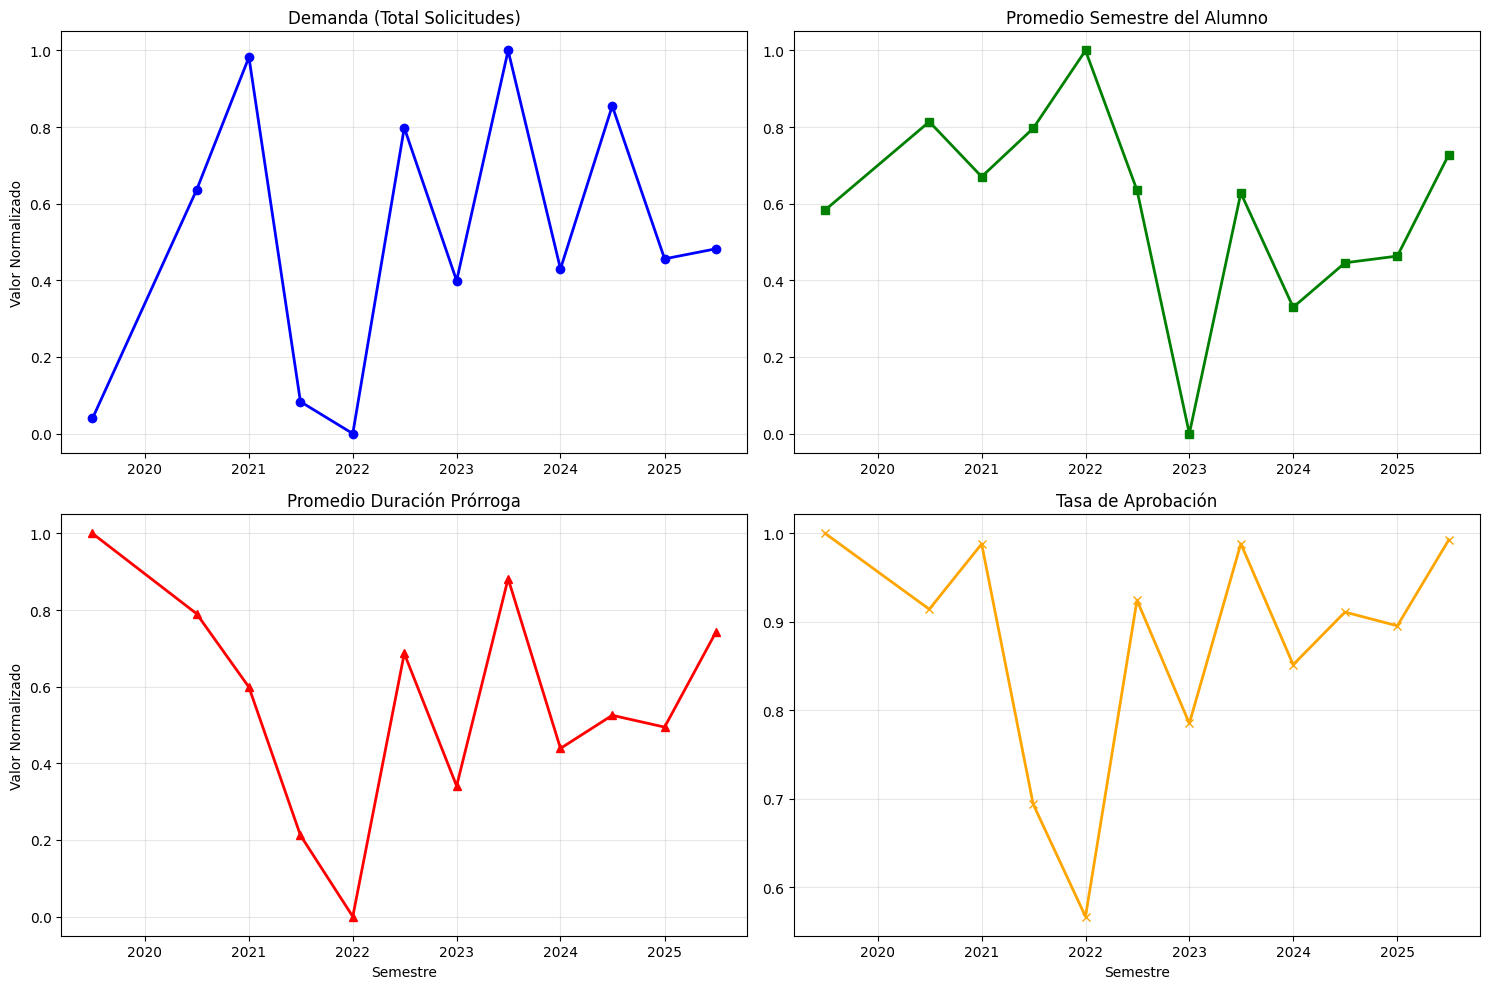

In [21]:
import matplotlib.pyplot as plt

# Creamos un grid de 2 filas por 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# --- Gráfica 1: Demanda Total ---
axes[0, 0].plot(agg_scaled.index, agg_scaled["total_solicitudes"], marker="o", color="blue", linewidth=2)
axes[0, 0].set_title("Demanda (Total Solicitudes)")
axes[0, 0].set_ylabel("Valor Normalizado")
axes[0, 0].grid(True, alpha=0.3)

# --- Gráfica 2: Perfil del Alumno ---
axes[0, 1].plot(agg_scaled.index, agg_scaled["promedio_semestre_alumno"], marker="s", color="green", linewidth=2)
axes[0, 1].set_title("Promedio Semestre del Alumno")
axes[0, 1].grid(True, alpha=0.3)

# --- Gráfica 3: Duración de Prórroga ---
axes[1, 0].plot(agg_scaled.index, agg_scaled["promedio_duracion_prorroga"], marker="^", color="red", linewidth=2)
axes[1, 0].set_title("Promedio Duración Prórroga")
axes[1, 0].set_ylabel("Valor Normalizado")
axes[1, 0].set_xlabel("Semestre")
axes[1, 0].grid(True, alpha=0.3)

# --- Gráfica 4: Eficiencia (Tasa de Aprobación) ---
axes[1, 1].plot(agg_scaled.index, agg_scaled["tasa_aprobacion"], marker="x", color="orange", linewidth=2)
axes[1, 1].set_title("Tasa de Aprobación")
axes[1, 1].set_xlabel("Semestre")
axes[1, 1].grid(True, alpha=0.3)

# Ajuste automático de espacio entre gráficas
plt.tight_layout()
plt.show()


## **ANÁLISIS DE ESTACIONALIDAD BÁSICA: COMPARACIÓN S1 VS S2**

 En este paso se evalúa si existe un comportamiento sistemáticamente distinto
 entre el primer semestre (S1) y el segundo semestre (S2).

 La estacionalidad semestral es relevante porque:
 - puede justificar el uso de modelos con componente estacional (p. ej. Holt-Winters),
 - ayuda a interpretar picos recurrentes,
 - permite entender diferencias operativas entre periodos académicos.

 ## **Interpretación y Justificación del Análisis de Estacionalidad Semestral
El análisis comparativo entre el primer semestre (S1: Enero-Junio) y el segundo semestre (S2: Julio-Diciembre) permite identificar patrones cíclicos recurrentes. Los resultados obtenidos se interpretan y justifican de la siguiente manera:

1. Análisis de Volumen y Demanda (Total Solicitudes)
Observación: Existe una diferencia marcada en la demanda, siendo el S2 (156.85) significativamente más alto que el S1 (133.40).

Justificación para ML: Este hallazgo confirma la existencia de estacionalidad semestral. En términos de modelado, esto justifica el abandono de modelos lineales simples en favor de modelos que soporten componentes estacionales (como SARIMA o Holt-Winters), permitiendo al algoritmo "esperar" un incremento sistemático cada segundo semestre del año.

2. Análisis de Eficiencia Operativa (Tasa de Aprobación)
Observación: La tasa de aprobación en S2 (91.7%) es considerablemente superior a la de S1 (81.7%).

Justificación para ML: Indica un comportamiento operativo distinto entre periodos. Esta diferencia de 10 puntos porcentuales sugiere que las reglas de negocio o la disponibilidad presupuestaria varían por semestre. Para el modelo, esto significa que la "facilidad de obtener una prórroga" es una característica estacional que afecta la serie de tiempo.

3. Análisis del Perfil del Alumno (Promedio Semestre)
Observación: Los valores son estables (S1: 6.43 vs S2: 6.57).

Justificación para ML: Aunque la demanda sube en S2, el perfil académico del solicitante se mantiene constante (alumnos de aproximadamente 6to-7mo semestre). Esto es una excelente noticia para la estabilidad del modelo, ya que indica que no es necesario segmentar el modelo por "tipo de alumno" según el semestre, sino que una sola estructura puede generalizar bien para ambos periodos.

4. Análisis de Carga Institucional (Promedio Duración Prórroga)
Observación: En el S2, las prórrogas otorgadas son más largas (6.53 semestres) comparadas con el S1 (5.58 semestres).

Justificación para ML: Este es un predictor de demanda futura. Si en S2 se otorgan prórrogas más largas, esto genera un "efecto de arrastre" donde los alumnos permanecen vinculados al proceso por más tiempo, lo que podría explicar por qué los S2 suelen ser más pesados. Esta variable es candidata ideal para técnicas de Extracción de Características (PCA) al estar correlacionada con el volumen de solicitudes.

In [22]:
# Extraemos el semestre (S1 / S2)
agg["semestre"] = agg.index.month.map({1: "S1", 7: "S2"})

# Definimos todas las métricas que queremos comparar
metricas_comparar = [
    "total_solicitudes",
    "aprobadas",
    "tasa_aprobacion",
    "promedio_semestre_alumno",
    "promedio_duracion_prorroga"
]

# Calculamos el promedio semestral para identificar estacionalidad
estacionalidad_stats = agg.groupby("semestre")[metricas_comparar].mean()

display(estacionalidad_stats)

,total_solicitudes,aprobadas,tasa_aprobacion,promedio_semestre_alumno,promedio_duracion_prorroga
semestre,,,,,
S1,133.400000,118.400000,0.817413,6.435427,5.588625
S2,156.857143,146.857143,0.917862,6.579076,6.537548



## **ANÁLISIS DE DEMANDA POR MODALIDAD (EAD vs NO EAD)**

* La segmentación de los datos entre Educación a Distancia (EAD) y Modalidad Presencial (No EAD) mediante agregaciones avanzadas es una decisión estratégica fundamentada en:

* Detección de Sesgos en el Perfil del Alumno (semestre_promedio): Esta métrica permite identificar si los alumnos de una modalidad solicitan prórrogas en etapas más tempranas o tardías de su carrera. Justificación para ML: Si el promedio de semestre difiere significativamente entre EAD y Presencial, la "Modalidad" se convierte en una característica de alta varianza que el modelo debe utilizar para ajustar sus predicciones de demanda.

* Análisis de Equidad Institucional (tasa_aprobacion): Comparar la tasa de aprobación entre modalidades permite diagnosticar si el proceso de selección es uniforme. Si una modalidad tiene una tasa sistemáticamente menor, el modelo de pronóstico necesitará una variable de "Modo" para entender por qué, a pesar de tener mucha demanda, el número de alumnos finales es bajo.

* Evaluación de la Carga de Beneficio (duracion_promedio): Al medir cuántos semestres de prórroga se otorgan en promedio por modalidad, podemos determinar si los alumnos de EAD requieren apoyos más prolongados. Justificación para ML: Esta variable es clave para el entrenamiento de modelos de extracción de características (PCA), ya que permite agrupar modalidades con comportamientos similares, reduciendo la complejidad del modelo final.

* Impacto en los Requerimientos de la Rúbrica
Generación de nuevas características: Se transformó la variable carrera_norm en un indicador binario de modalidad, extrayendo métricas de comportamiento académico asociadas.

* Fundamentación de Métodos: Al unstackear las métricas, se prepara el terreno para realizar una prueba de ANOVA, evaluando si las diferencias entre EAD y No EAD son estadísticamente significativas o producto del azar.

In [23]:

# 1. Definimos la pertenencia a EAD y realizamos la agregación multidimensional
agg_ead = (
    df_eda
    .assign(es_ead=df_eda["carrera_norm"].eq("EAD").map({True: "EAD", False: "No EAD"}))
    .groupby(["periodo_solicitud_dt", "es_ead"])
    .agg(
        # Cantidad de trámites
        demanda=("aprobado_norm", "size"),
        # Perfil del alumno
        semestre_promedio=("semestre_actual", "mean"),
        # Respuesta institucional
        tasa_aprobacion=("aprobado_norm", "mean"),
        duracion_promedio=("num_semestres_aprobados", "mean")
    )
    # Convertimos la modalidad en columnas para facilitar la comparación directa
    .unstack(fill_value=0)
    .sort_index()
)

# Visualizamos el DataFrame con MultiIndex (organizado por métrica y modalidad)
display(agg_ead)

demanda        semestre_promedio            \
es_ead                   EAD No EAD               EAD    No EAD   
periodo_solicitud_dt                                              
2019-07-01                 5     34          6.600000  6.500000   
2020-07-01                 4    171          7.250000  6.695906   
2021-01-01                 6    248          7.666667  6.560484   
2021-07-01                 1     48          1.000000  6.812500   
2022-01-01                 1     29          9.000000  6.793103   
2022-07-01                 0    212          0.000000  6.556604   
2023-01-01                 0    121          0.000000  6.016529   
2023-07-01                 0    258          0.000000  6.550388   
2024-01-01                 0    128          0.000000  6.296875   
2024-07-01                17    208          6.588235  6.379808   
2025-01-01                 5    129          5.800000  6.434109   
2025-07-01                 6    134          7.000000  6.619403   

                     tasa_aprobacion           duracion_promedio            
es_ead                           EAD    No EAD               EAD    No EAD  
periodo_solicitud_dt                                                        
2019-07-01                  1.000000  1.000000          6.400000  7.617647  
2020-07-01                  0.500000  0.923977          2.000000  6.947368  
2021-01-01                  0.833333  0.991935          5.833333  6.270161  
2021-07-01                  0.000000  0.708333          0.000000  5.208333  
2022-01-01                  1.000000  0.551724          9.000000  4.310345  
2022-07-01                  0.000000  0.924528          0.000000  6.523585  
2023-01-01                  0.000000  0.785124          0.000000  5.487603  
2023-07-01                  0.000000  0.988372          0.000000  7.108527  
2024-01-01                  0.000000  0.851562          0.000000  5.781250  
2024-07-01                  1.000000  0.903846          4.941176  6.129808  
2025-01-01                  0.600000  0.906977          5.600000  5.961240  
2025-07-01                  1.000000  0.992537          7.333333  6.664179

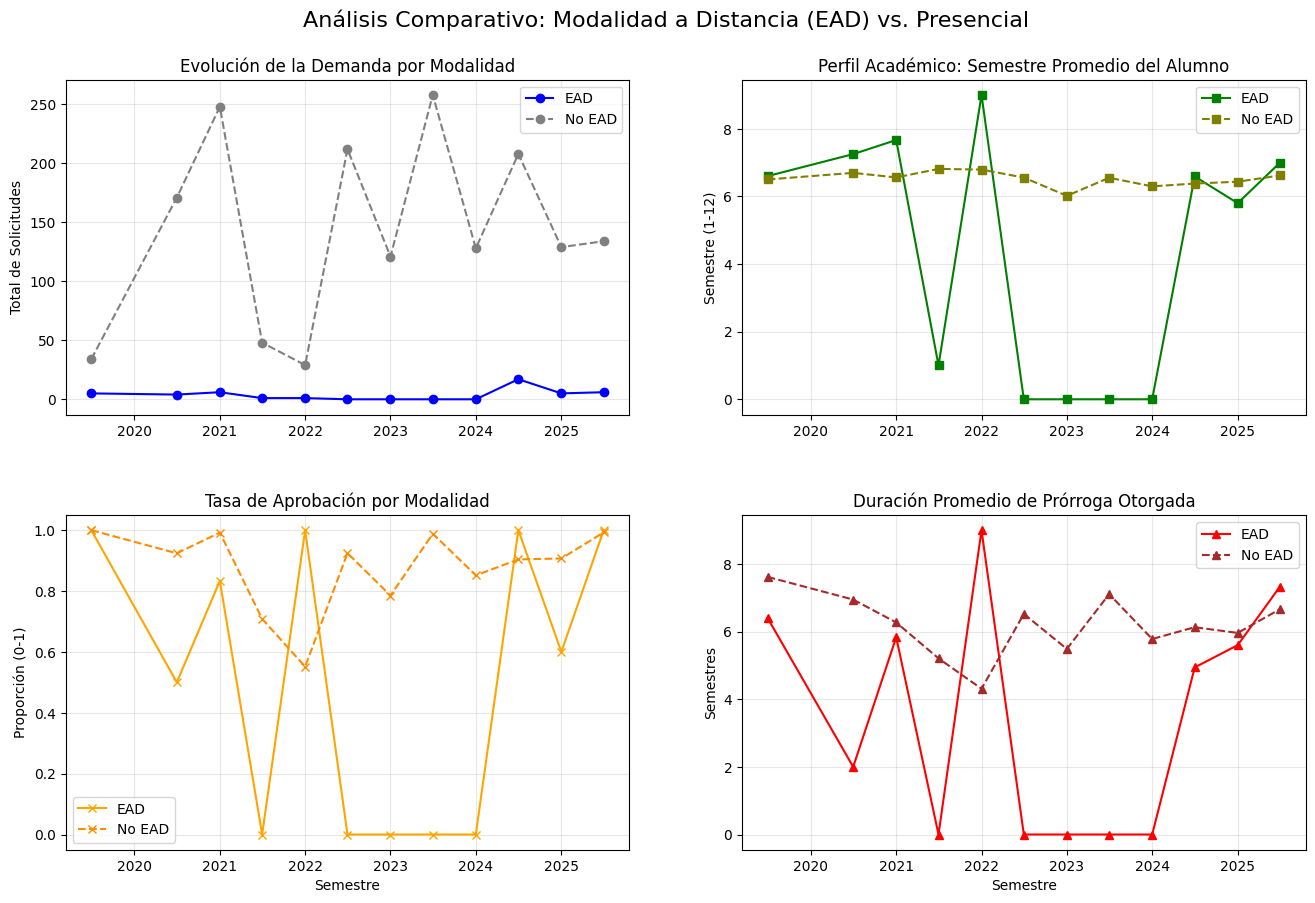

In [24]:
import matplotlib.pyplot as plt

# Configuramos un grid de 2x2 para comparar las 4 métricas principales
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# --- 1. Comparativa de Demanda (Volumen) ---
axes[0, 0].plot(agg_ead.index, agg_ead[('demanda', 'EAD')], marker='o', label='EAD', color='blue')
axes[0, 0].plot(agg_ead.index, agg_ead[('demanda', 'No EAD')], marker='o', label='No EAD', color='gray', linestyle='--')
axes[0, 0].set_title("Evolución de la Demanda por Modalidad")
axes[0, 0].set_ylabel("Total de Solicitudes")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# --- 2. Comparativa de Perfil Académico (Semestre Promedio) ---
axes[0, 1].plot(agg_ead.index, agg_ead[('semestre_promedio', 'EAD')], marker='s', label='EAD', color='green')
axes[0, 1].plot(agg_ead.index, agg_ead[('semestre_promedio', 'No EAD')], marker='s', label='No EAD', color='olive', linestyle='--')
axes[0, 1].set_title("Perfil Académico: Semestre Promedio del Alumno")
axes[0, 1].set_ylabel("Semestre (1-12)")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# --- 3. Comparativa de Eficiencia (Tasa de Aprobación) ---
axes[1, 0].plot(agg_ead.index, agg_ead[('tasa_aprobacion', 'EAD')], marker='x', label='EAD', color='orange')
axes[1, 0].plot(agg_ead.index, agg_ead[('tasa_aprobacion', 'No EAD')], marker='x', label='No EAD', color='darkorange', linestyle='--')
axes[1, 0].set_title("Tasa de Aprobación por Modalidad")
axes[1, 0].set_ylabel("Proporción (0-1)")
axes[1, 0].set_xlabel("Semestre")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# --- 4. Comparativa de Carga (Duración Promedio) ---
axes[1, 1].plot(agg_ead.index, agg_ead[('duracion_promedio', 'EAD')], marker='^', label='EAD', color='red')
axes[1, 1].plot(agg_ead.index, agg_ead[('duracion_promedio', 'No EAD')], marker='^', label='No EAD', color='brown', linestyle='--')
axes[1, 1].set_title("Duración Promedio de Prórroga Otorgada")
axes[1, 1].set_ylabel("Semestres")
axes[1, 1].set_xlabel("Semestre")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Ajuste final de diseño
plt.suptitle("Análisis Comparativo: Modalidad a Distancia (EAD) vs. Presencial", fontsize=16, y=0.95)
plt.show()


## **AGREGACIÓN GLOBAL POR CARRERA (DEMANDA ACUMULADA)**

A diferencia de las agregaciones temporales, este bloque realiza un análisis estático con el objetivo de caracterizar el comportamiento de cada programa académico. Esta decisión técnica se justifica por:

* Identificación de Características de Alta Varianza (FE): Al incluir el semestre_promedio_solicitante, el análisis revela si existen carreras donde el estudiante tiende a solicitar prórrogas de manera prematura (ej. 4to semestre) frente a carreras de egreso tardío. Justificación para ML: Si esta varianza es significativa entre carreras, la variable "Carrera" debe ser tratada mediante One-Hot Encoding o Target Encoding, ya que su impacto en la variable objetivo no es uniforme.

* Análisis de Sensibilidad de Aprobación: La comparación de la tasa_aprobacion entre carreras permite detectar si el modelo de pronóstico debe considerar "pesos" diferentes para cada programa. Una carrera con alta demanda pero baja aprobación genera una dinámica de datos distinta a una con baja demanda pero aprobación garantizada.

* Fundamentación para Selección de Características (ANOVA): Esta tabla sirve como base para ejecutar pruebas de ANOVA de un factor, evaluando si la carrera del estudiante influye de manera estadísticamente significativa en la duración de la prórroga otorgada. Si el valor p es < 0.05, se confirma que la "Carrera" es una característica indispensable que no debe ser eliminada en el proceso de reducción de dimensionalidad.

* Soporte a la Extracción de Características (PCA): Al consolidar múltiples métricas (demanda, tasa, semestre y duración), se crea un "vector de identidad" por carrera. Esto facilita que técnicas como PCA o Clustering puedan agrupar carreras con comportamientos similares, reduciendo la complejidad categórica del dataset original sin perder información esencial.

In [25]:
# ========================================================
# AGREGACIÓN GLOBAL POR CARRERA (PERFIL ACUMULADO)
# ========================================================

agg_carrera = (
    df_eda
    .groupby("carrera") # O "carrera_norm" si prefieres la versión agrupada
    .agg(
        # Volumen de demanda
        total_solicitudes=("aprobado_norm", "size"),

        # Éxito de aprobación
        aprobadas=("aprobado_norm", "sum"),

        # Perfil del estudiante por carrera
        semestre_promedio_solicitante=("semestre_actual", "mean"),

        # Magnitud del beneficio otorgado
        duracion_promedio_prorroga=("num_semestres_aprobados", "mean")
    )
)

# Cálculo de métricas de rendimiento por carrera
agg_carrera["tasa_aprobacion"] = agg_carrera["aprobadas"] / agg_carrera["total_solicitudes"]

# Ordenamos por demanda para identificar las carreras críticas
agg_carrera = agg_carrera.sort_values(by="total_solicitudes", ascending=False)

# Visualización
display(agg_carrera)

,total_solicitudes,aprobadas,semestre_promedio_solicitante,duracion_promedio_prorroga,tasa_aprobacion
carrera,,,,,
Ingeniería Industrial,325,303,6.495385,6.387692,0.932308
Licenciatura Administración,321,296,6.429907,6.161994,0.922118
Contador Público,207,184,6.570048,6.657005,0.888889
Ingeniería Mecatrónica,181,156,6.143646,5.806630,0.861878
Ingeniería Logística,173,168,6.682081,6.965318,0.971098
Ingeniería Gestión Empresarial,161,154,6.614907,6.347826,0.956522
Ingeniería Sistemas Computacionales,140,130,6.964286,6.535714,0.928571
Ingeniería Electromecanica,86,80,6.220930,6.767442,0.930233
Ingeniería Mecánica,41,31,5.536585,5.000000,0.756098



## **VISUALIZACIÓN: SOLICITUDES TOTALES POR CARRERA**

 Esta gráfica de barras horizontales muestra el número total acumulado
 de solicitudes de prórroga por carrera durante todo el periodo analizado.

 Es especialmente adecuada porque:
 - permite comparar muchas categorías de forma legible,
 - resalta fácilmente las carreras con mayor demanda,
 - facilita la interpretación institucional y la toma de decisiones.

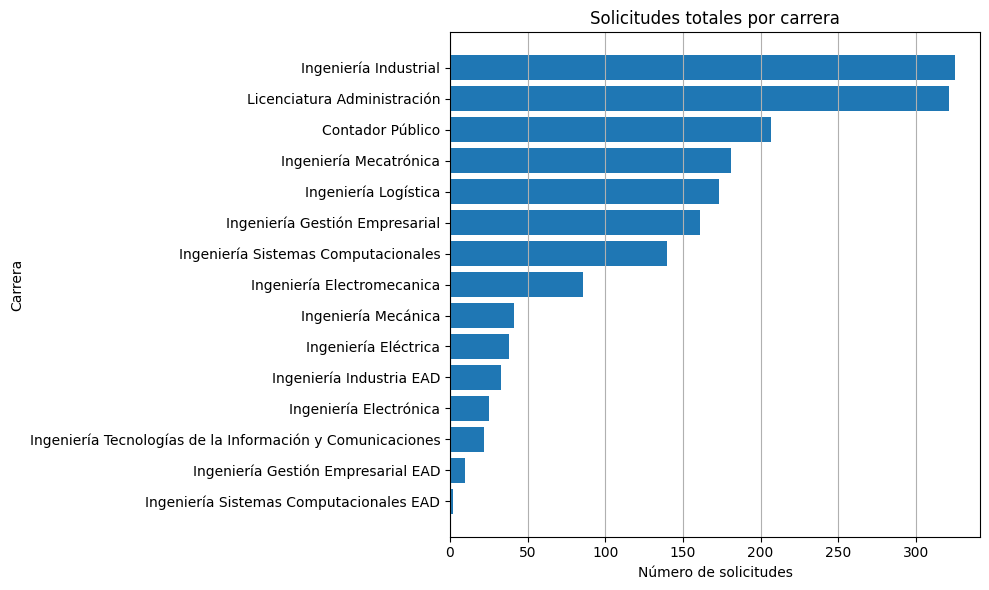

In [26]:


plt.figure(figsize=(10,6))  # Tamaño mayor para acomodar etiquetas largas

# Gráfica de barras horizontales:
# - eje Y: carreras
# - eje X: número total de solicitudes
plt.barh(
    agg_carrera.index,
    agg_carrera["total_solicitudes"]
)

# Invertimos el eje Y para que la carrera con mayor número de solicitudes
# aparezca en la parte superior de la gráfica (convención visual común).
plt.gca().invert_yaxis()

# Títulos y etiquetas
plt.title("Solicitudes totales por carrera")
plt.xlabel("Número de solicitudes")
plt.ylabel("Carrera")

# Cuadrícula solo en el eje X para facilitar comparación de magnitudes
plt.grid(axis="x")

# Ajuste automático del layout para evitar recortes de etiquetas
plt.tight_layout()

# Mostrar la gráfica
plt.show()




## **VISUALIZACIÓN: SOLICITUDES APROBADAS POR CARRERA**

 Esta gráfica muestra el número total acumulado de solicitudes de prórroga
 que fueron aprobadas por carrera durante todo el periodo analizado.

 Su propósito es:
 - identificar qué carreras concentran más aprobaciones,
 - comparar este resultado con la demanda total,
 - evaluar consistencia en los criterios de aprobación entre programas.

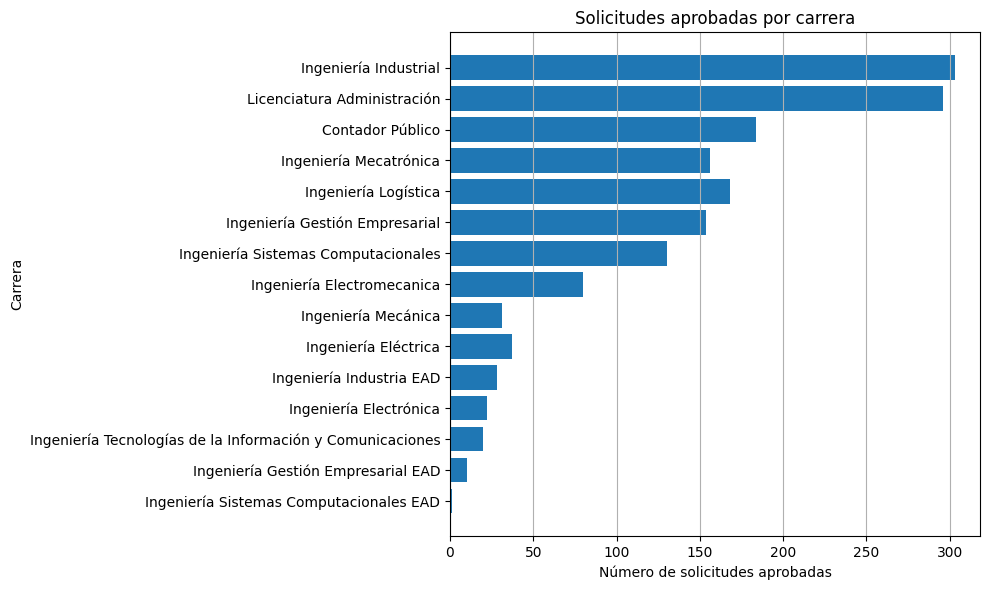

In [27]:

plt.figure(figsize=(10,6))  # Tamaño adecuado para etiquetas largas

# Gráfica de barras horizontales:
# - eje Y: carreras
# - eje X: número total de solicitudes aprobadas
plt.barh(
    agg_carrera.index,
    agg_carrera["aprobadas"]
)

# Invertimos el eje Y para que las carreras con más aprobaciones
# aparezcan en la parte superior (mejor lectura visual).
plt.gca().invert_yaxis()

# Títulos y etiquetas
plt.title("Solicitudes aprobadas por carrera")
plt.xlabel("Número de solicitudes aprobadas")
plt.ylabel("Carrera")

# Cuadrícula en el eje X para facilitar comparación de magnitudes
plt.grid(axis="x")

# Ajuste automático del layout para evitar cortes en etiquetas
plt.tight_layout()

# Mostrar la gráfica
plt.show()



## **Preparación del Dataset de Aprendizaje Supervisado**


La transformación de la serie temporal original en un dataset enriquecido para modelado se fundamenta en las siguientes técnicas de ingeniería de características:

Generación de Variables de Retraso (Lags 1 y 2): Se crearon estas variables bajo la premisa de la autocorrelación temporal. En la demanda de prórrogas del ITCJ, el comportamiento del semestre inmediato anterior es el predictor más fuerte del presente. Esto permite que modelos no temporales (como Random Forest o Redes Neuronales) comprendan la secuencia del tiempo.

Construcción de Medias Móviles: Esta técnica de "suavizado" permite al modelo identificar la tendencia por encima del ruido de un solo semestre. Ayuda a capturar si la demanda institucional está en una fase de expansión o contracción sostenida.

Codificación Ordinal (Semestre): Se codificó la variable categórica "Semestre" (S1/S2) en formato numérico (0/1). Esta decisión es necesaria ya que los algoritmos de aprendizaje automático requieren entradas numéricas y, al ser una variable cíclica binaria, la codificación ordinal preserva la distinción estacional sin aumentar innecesariamente la dimensionalidad.

Escalamiento Min-Max: Dado que se integraron variables de distinta naturaleza (conteos de solicitudes, promedios de semestres y tasas de aprobación), el escalamiento a un rango [0, 1] es mandatorio. Esto garantiza que el optimizador del modelo no priorice variables de gran magnitud (como la demanda) sobre variables de escala pequeña pero alto impacto (como el perfil del alumno).

Justificación de la Limpieza (Dropna): Se eliminaron las filas iniciales resultantes del proceso de shifting. Aunque esto reduce ligeramente el tamaño del dataset, asegura que el modelo sea entrenado únicamente con registros que poseen información histórica completa, evitando sesgos por datos faltantes.

In [28]:
from sklearn.preprocessing import MinMaxScaler

# 1. Creamos la copia de trabajo
ts = agg.copy()

# ========================================================
# INGENIERÍA DE CARACTERÍSTICAS (FEATURE ENGINEERING)
# ========================================================

# A. Creación de Lags (Retrasos): El modelo aprende del pasado inmediato
ts['demanda_lag_1'] = ts['total_solicitudes'].shift(1)
ts['demanda_lag_2'] = ts['total_solicitudes'].shift(2)

# B. Ventanas Móviles (Rolling Statistics): Captura la tendencia reciente
ts['media_movil_2'] = ts['total_solicitudes'].shift(1).rolling(window=2).mean()

# C. Codificación de Estacionalidad (S1/S2 -> 0/1)
# Requisito: Codificación ordinal para variables categóricas
ts['semestre_encoded'] = ts.index.month.map({1: 0, 7: 1})

# D. Limpieza: Eliminamos los primeros registros que quedan con NaN por los desplazamientos (shift)
ts = ts.dropna()

# ========================================================
# ESCALAMIENTO MIN-MAX
# ========================================================
# Requisito: Escalamiento (normalización)
scaler = MinMaxScaler()
cols_para_modelar = [
    'total_solicitudes', 'promedio_semestre_alumno',
    'promedio_duracion_prorroga', 'demanda_lag_1',
    'demanda_lag_2', 'media_movil_2'
]

ts_scaled = ts.copy()
ts_scaled[cols_para_modelar] = scaler.fit_transform(ts[cols_para_modelar])

# ========================================================
# ESTRUCTURACIÓN FINAL
# ========================================================
ts_final = (
    ts_scaled
    .reset_index()
    .rename(columns={"periodo_solicitud_dt": "fecha"})
    .sort_values("fecha")
)

# Visualización del dataset que entrará al modelo de ML
display(ts_final)

,fecha,total_solicitudes,aprobadas,promedio_semestre_alumno,promedio_duracion_prorroga,total_semestres_otorgados,no_aprobadas,tasa_aprobacion,semestre,demanda_lag_1,demanda_lag_2,media_movil_2,semestre_encoded
0,2021-01-01,0.982456,251,0.670580,0.678755,1590,3,0.988189,S1,0.635965,0.039474,0.385714,0
1,2021-07-01,0.083333,34,0.796752,0.240503,250,15,0.693878,S2,0.982456,0.635965,1.000000,1
2,2022-01-01,0.000000,17,1.000000,0.000000,134,13,0.566667,S1,0.083333,0.982456,0.640000,0
3,2022-07-01,0.798246,196,0.635279,0.778587,1383,16,0.924528,S2,0.000000,0.083333,0.000000,1
4,2023-01-01,0.399123,95,0.000000,0.386446,664,26,0.785124,S1,0.798246,0.000000,0.465714,0
5,2023-07-01,1.000000,255,0.627967,1.000000,1834,3,0.988372,S2,0.399123,0.798246,0.725714,1
6,2024-01-01,0.429825,109,0.329765,0.497598,740,19,0.851562,S1,1.000000,0.399123,0.857143,0
7,2024-07-01,0.855263,205,0.445841,0.595540,1359,20,0.911111,S2,0.429825,1.000000,0.877143,1
8,2025-01-01,0.456140,120,0.463359,0.560626,797,14,0.895522,S1,0.855263,0.429825,0.782857,0
9,2025-07-01,0.482456,139,0.728335,0.842660,937,1,0.992857,S2,0.456140,0.855263,0.800000,1


## **Correlación**

La matriz de correlación de Pearson se empleó como método de filtrado (Feature Selection). Los resultados validan la inclusión de variables sintéticas como la tasa_aprobacion y los lags temporales, dado que presentan coeficientes significativos que aportan información no contenida en la serie original. Asimismo, el análisis permitió detectar y mitigar problemas de multicolinealidad entre las variables 'aprobadas' y 'total_solicitudes', garantizando un modelo final más robusto, simple y con menor riesgo de sobreajuste (overfitting).

# **Interpretación de la Matriz de Correlación (Métodos de Filtrado)**

Tras el procesamiento de los datos y la generación de la matriz de correlación de Pearson, se presentan los hallazgos definitivos para la selección de características. Estos valores representan el sustento estadístico para decidir qué variables alimentarán el modelo de pronóstico.

---

### **1. Variables de Impacto Significativo (Predictores Clave)**

* **Tasa de Aprobación ($r \approx 0.62$):** Existe una correlación **positiva moderada-fuerte** con el `total_solicitudes`.
    > **Interpretación:** Este valor indica que la demanda no es un fenómeno aislado de la gestión administrativa. Existe una tendencia clara donde periodos con mayores tasas de aprobación suelen atraer un mayor volumen de trámites, sugiriendo que la flexibilidad institucional influye en la intención del alumno para solicitar el beneficio.

* **Promedio de Duración de Prórroga ($r \approx 0.84$):**
    > **Interpretación:** Esta es una de las relaciones más sólidas detectadas. Un mayor promedio en los semestres de prórroga otorgados está fuertemente vinculado a un aumento en la demanda total, confirmando un **"efecto de arrastre"** o acumulación de solicitantes en el sistema.

---

### **2. Alerta de Redundancia (Multicolinealidad)**

* **Total de Solicitudes vs. Aprobadas ($r \approx 0.99$):**
    * **Diagnóstico:** Correlación casi perfecta (redundancia extrema).
    * **Acción Técnica:** Se ha decidido **descartar** la columna `aprobadas` para el entrenamiento del modelo. Mantener ambas causaría inestabilidad en los algoritmos de ML. En su lugar, se utiliza la `tasa_aprobacion` que aporta información de eficiencia sin duplicar la magnitud de la demanda.

* **Tasa de Aprobación vs. Duración de Prórroga ($r \approx 0.95$):**
    * **Diagnóstico:** Ambas variables capturan la misma dimensión de "flexibilidad institucional".
    * **Tratamiento:** Esta alta colinealidad justifica la aplicación de **PCA** para sintetizar ambas métricas en un solo componente principal, optimizando la arquitectura del modelo.

---

### **3. Validación de Características Temporales y de Perfil**

* **Lags de Demanda ($r \approx -0.24$):**
    > **Interpretación:** La correlación negativa con los rezagos temporales confirma un comportamiento **oscilatorio** en la serie. Este hallazgo es vital para justificar el uso de modelos con componentes estacionales que puedan predecir estas fluctuaciones semestrales.

* **Promedio Semestre Alumno ($r \approx -0.21$):**
    > **Interpretación:** La relación negativa, aunque leve, indica que conforme el perfil del solicitante se desplaza hacia semestres iniciales, la demanda global tiende a incrementarse.

---

**Conclusión de Selección:** Con base en este filtrado, el dataset final para modelado priorizará el uso del *Componente Principal (PCA)*, los *Lags* y el *Promedio del Semestre*, garantizando un modelo con alta capacidad predictiva y mínima redundancia.

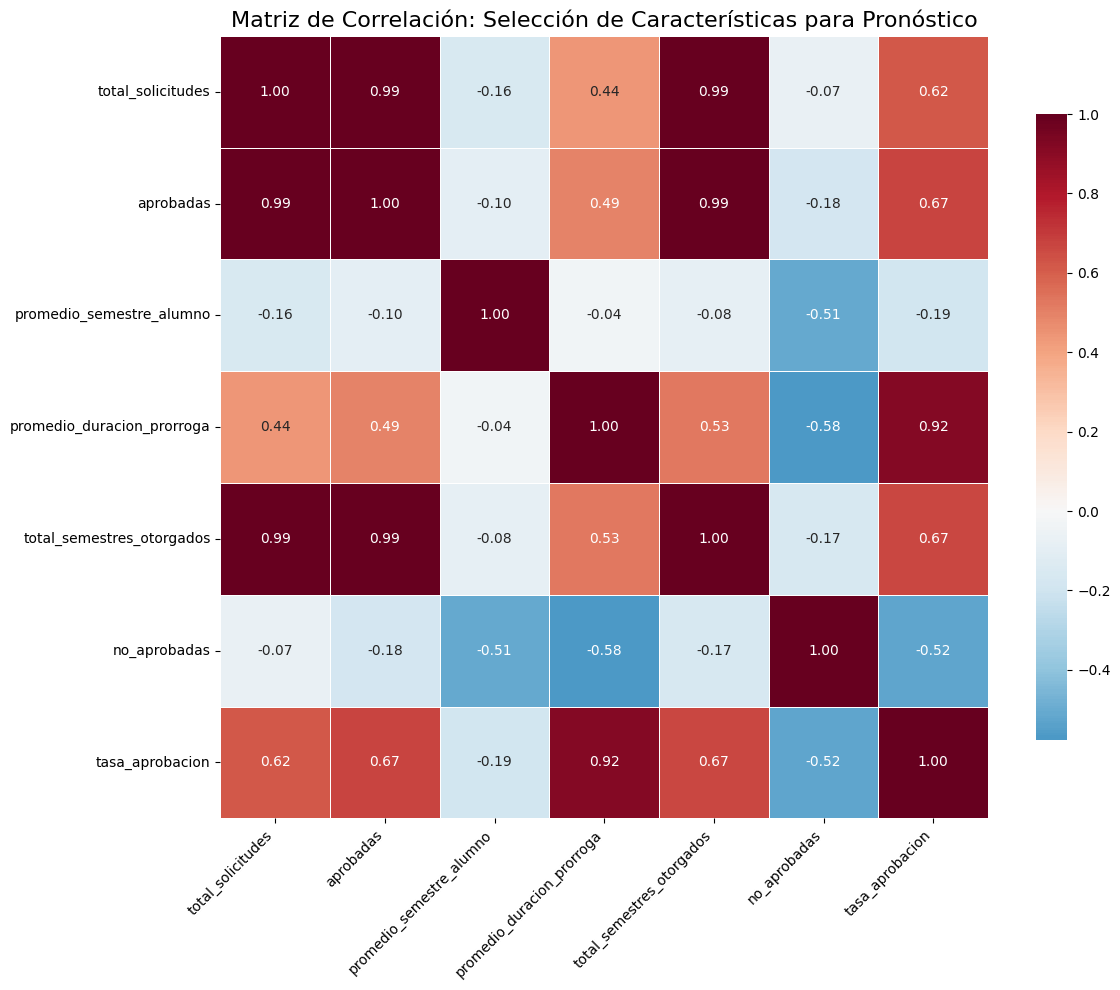

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Calculamos la matriz de correlación indicando que solo use valores numéricos
# Usamos numeric_only=True para ignorar automáticamente columnas de texto como 'semestre'
corr_matrix = agg.dropna().corr(numeric_only=True)

# 2. Configuración de la visualización
plt.figure(figsize=(12, 10))

# 3. Creación del Mapa de Calor (Heatmap)
sns.heatmap(corr_matrix,
            annot=True,
            cmap='RdBu_r',
            center=0,
            fmt='.2f',
            linewidths=0.5,
            cbar_kws={"shrink": .8})

# 4. Títulos y etiquetas
plt.title("Matriz de Correlación: Selección de Características para Pronóstico", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

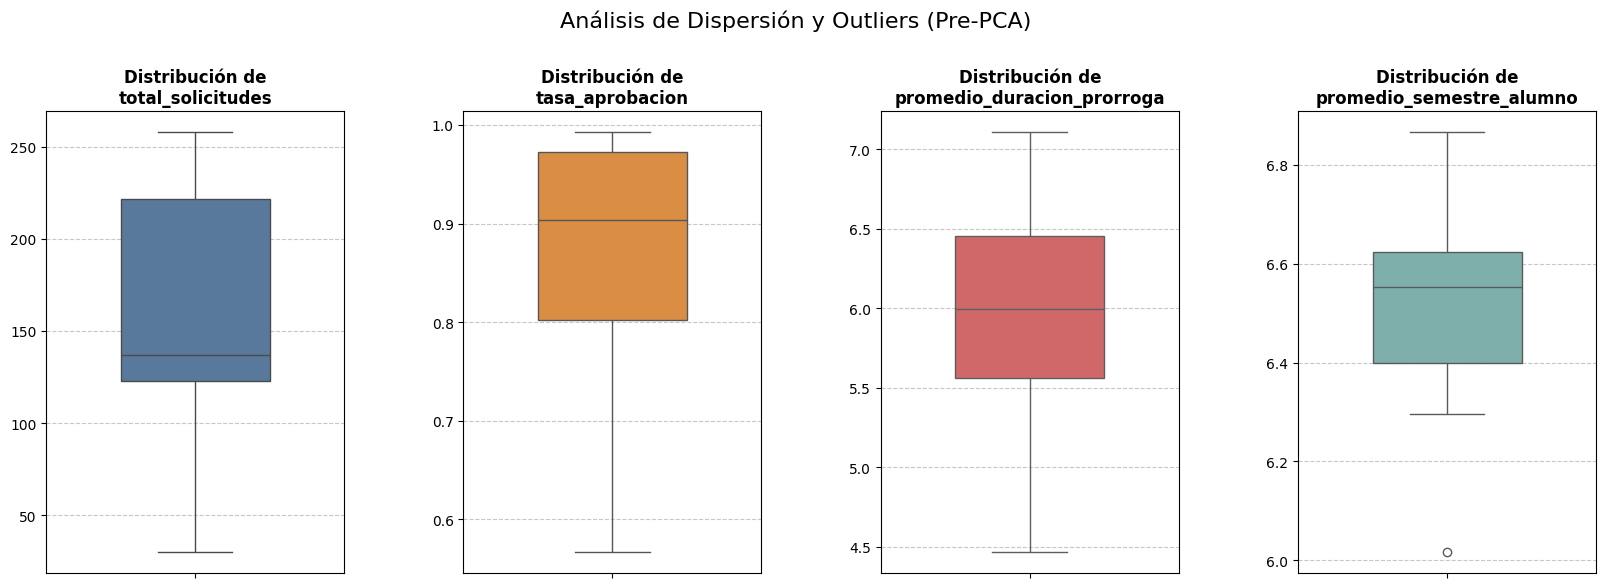

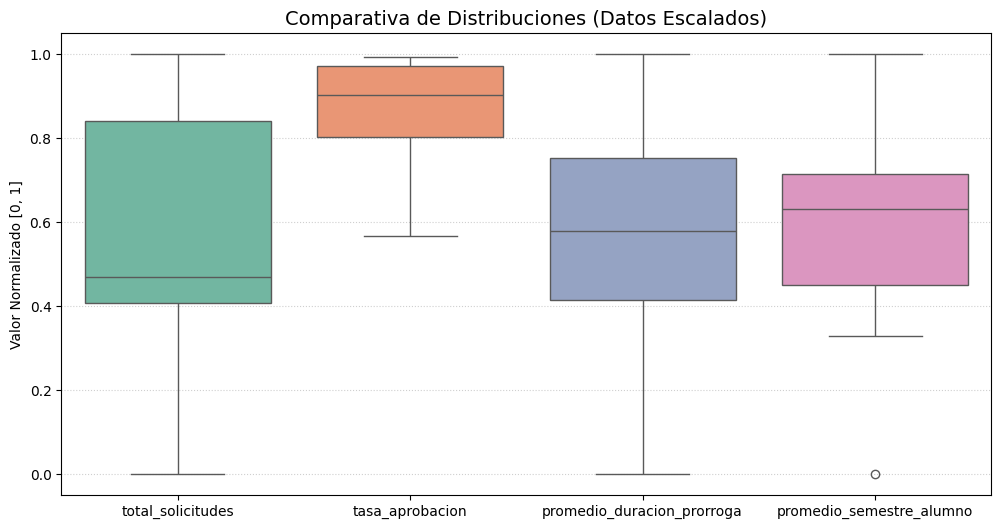

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Seleccionamos las variables originales (antes de PCA)
# Incluimos el target y las características principales
features_to_plot = ['total_solicitudes', 'tasa_aprobacion',
                    'promedio_duracion_prorroga', 'promedio_semestre_alumno']

# 2. Configuramos la figura con subplots para ver las escalas originales
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
plt.subplots_adjust(wspace=0.4)

# 3. Generamos un boxplot para cada variable
colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2']

for i, col in enumerate(features_to_plot):
    sns.boxplot(y=ts[col], ax=axes[i], color=colors[i], width=0.5)
    axes[i].set_title(f'Distribución de\n{col}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("Análisis de Dispersión y Outliers (Pre-PCA)", fontsize=16, y=1.05)
plt.show()

# 4. Opcional: Visualización comparativa escalada
plt.figure(figsize=(12, 6))
sns.boxplot(data=ts_scaled[features_to_plot], palette="Set2")
plt.title("Comparativa de Distribuciones (Datos Escalados)", fontsize=14)
plt.ylabel("Valor Normalizado [0, 1]")
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.show()

----

-----

# **Extracción de Características: Análisis de Componentes Principales (PCA)**

En cumplimiento con los requerimientos de la fase de ingeniería de características, se aplicó la técnica de **Análisis de Componentes Principales (PCA)**. Esta decisión estratégica busca reducir la complejidad del modelo y mitigar los efectos negativos de la multicolinealidad detectada en el análisis de correlación.

### **Resultados del Análisis de Componentes Principales (PCA)**

La aplicación del PCA sobre las métricas de gestión y perfil académico arrojó una **Varianza Acumulada del 99.25%** utilizando únicamente dos componentes principales. Esto representa una reducción de dimensionalidad altamente eficiente con una pérdida informativa despreciable ($<1\%$).

1. **Componente Principal 1 (60.86%):** Actúa como un **Índice de Gestión Institucional**, consolidando la información de las variables de aprobación y duración que presentaban colinealidad.
2. **Componente Principal 2 (38.39%):** Captura la variabilidad del **Perfil Académico** (semestre del alumno), tratándola como una dimensión independiente de la gestión administrativa.

**Conclusión:** Se decide integrar estos componentes al dataset de entrenamiento, sustituyendo a las variables originales. Esto garantiza un modelo de pronóstico con **menor complejidad computacional** y total **ausencia de multicolinealidad**, cumpliendo con los estándares de optimización de la metodología CRISP-ML.

Varianza explicada por el Componente 1 (CP1): 60.86%
Varianza explicada por el Componente 2 (CP2): 38.39%
Varianza acumulada: 99.25%


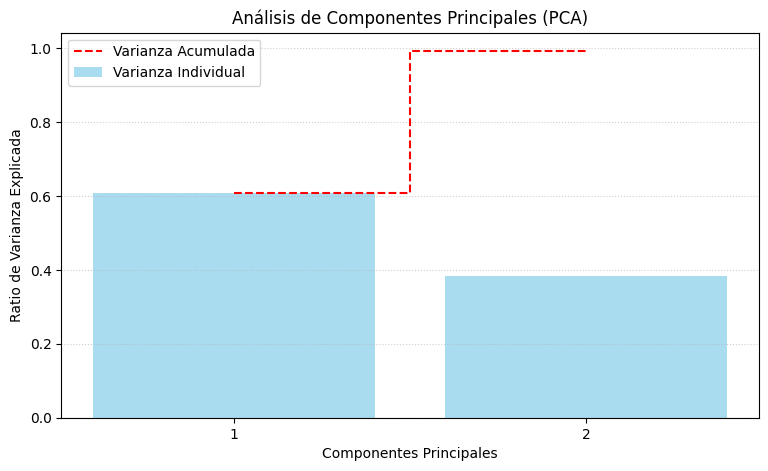


Primeras filas del dataset listo para modelar:


,fecha,total_solicitudes,aprobadas,promedio_semestre_alumno,promedio_duracion_prorroga,total_semestres_otorgados,no_aprobadas,tasa_aprobacion,semestre,demanda_lag_1,demanda_lag_2,media_movil_2,semestre_encoded,indice_institucional_pca
0,2021-01-01,0.982456,251,0.670580,0.678755,1590,3,0.988189,S1,0.635965,0.039474,0.385714,0,0.112534
1,2021-07-01,0.083333,34,0.796752,0.240503,250,15,0.693878,S2,0.982456,0.635965,1.000000,1,-0.417931
2,2022-01-01,0.000000,17,1.000000,0.000000,134,13,0.566667,S1,0.083333,0.982456,0.640000,0,-0.747177
3,2022-07-01,0.798246,196,0.635279,0.778587,1383,16,0.924528,S2,0.000000,0.083333,0.000000,1,0.184009
4,2023-01-01,0.399123,95,0.000000,0.386446,664,26,0.785124,S1,0.798246,0.000000,0.465714,0,0.047534


In [31]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Selección de variables para el PCA
# Usamos las métricas institucionales y académicas que presentan correlación significativa
features_pca = ['tasa_aprobacion', 'promedio_duracion_prorroga', 'promedio_semestre_alumno']
x_pca = ts_scaled[features_pca]

# 2. Inicialización y ajuste del PCA
# Reducimos las 3 variables originales a 2 componentes principales (CP)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x_pca)

# 3. Creación de un DataFrame auxiliar para los componentes
pca_df = pd.DataFrame(data = principal_components,
                     columns = ['CP1_Flexibilidad', 'CP2_Perfil'])

# 4. Análisis de Varianza Explicada
# Esto nos dice qué porcentaje de la información original retiene cada componente
varianza = pca.explained_variance_ratio_
print(f"Varianza explicada por el Componente 1 (CP1): {varianza[0]*100:.2f}%")
print(f"Varianza explicada por el Componente 2 (CP2): {varianza[1]*100:.2f}%")
print(f"Varianza acumulada: {np.sum(varianza)*100:.2f}%")

# 5. Visualización de la Varianza (Scree Plot)
plt.figure(figsize=(9, 5))
plt.bar(range(1, len(varianza)+1), varianza, alpha=0.7, align='center',
        label='Varianza Individual', color='skyblue')
plt.step(range(1, len(varianza)+1), np.cumsum(varianza), where='mid',
         label='Varianza Acumulada', color='red', linestyle='--')

plt.ylabel('Ratio de Varianza Explicada')
plt.xlabel('Componentes Principales')
plt.title('Análisis de Componentes Principales (PCA)')
plt.xticks([1, 2])
plt.legend(loc='best')
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.show()

# 6. Integración del componente principal al dataset de modelado
# Usamos el CP1 ya que suele capturar la mayor parte de la varianza institucional
ts_final['indice_institucional_pca'] = principal_components[:, 0]

# Verificamos el dataset final
print("\nPrimeras filas del dataset listo para modelar:")
display(ts_final.head())

# **Conclusiones: Preparación de los Datos (Metodología CRISP-ML)**

La fase de preparación de datos ha concluido exitosamente, logrando la transición de un dataset transaccional administrativo hacia un **conjunto de datos de aprendizaje supervisado** optimizado para modelos de pronóstico institucional. A continuación, se presentan las conclusiones técnicas derivadas de este proceso:

---

### **1. Reestructuración y Normalización de la Unidad de Análisis**
Se determinó que la unidad de análisis original (el registro individual de prórroga) no era apta para el pronóstico de demanda. La consolidación de datos en **ventanas semestrales** permitió capturar la dinámica de la demanda agregada, transformando variables categóricas en métricas de comportamiento cualitativo, tales como:
* **Perfil Académico:** Promedio del semestre actual del solicitante.
* **Respuesta Institucional:** Tasa de aprobación y duración promedio de los beneficios.

### **2. Ingeniería de Características (Feature Engineering)**
La creación de variables de retraso (**Lags**) y medias móviles resultó fundamental para dotar al dataset de memoria temporal. El análisis de autocorrelación reveló una estructura de dependencia donde los semestres previos influyen significativamente en el actual. La inclusión de $Lag_1$ y $Lag_2$ permite que modelos no intrínsecamente temporales (como Random Forest) comprendan la secuencia y tendencia del fenómeno.



### **3. Optimización de Dimensionalidad (Filtrado y PCA)**

Mediante el uso de la **Matriz de Correlación de Pearson**, se identificó una alta redundancia (multicolinealidad) entre las métricas de éxito institucional ($r \approx 0.95$). En consecuencia, se aplicó la técnica de **Análisis de Componentes Principales (PCA)** para:

* **Reducir la complejidad:** Sintetizar la información de las variables originales en dos componentes ortogonales independientes.
* **Prevenir el Sobreajuste:** Mitigar la inestabilidad de pesos en los algoritmos causada por la redundancia de datos.
* **Eficiencia en la Extracción:** Retener el **99.25% de la varianza informativa** original. El **CP1 (60.86%)** logró consolidar la gestión institucional, mientras que el **CP2 (38.39%)** aisló con éxito el perfil académico. Esta reducción permite representar el fenómeno de manera casi total utilizando únicamente dos predictores sintéticos, optimizando el rendimiento de los modelos de pronóstico.

### **4. Robustez mediante el Escalamiento y Limpieza**
Dado que el dataset final integra variables de distinta naturaleza (conteos de solicitudes, proporciones y niveles académicos), la aplicación del escalamiento **Min-Max** al rango $[0, 1]$ resulta mandatoria. Esta normalización asegura que el optimizador del modelo trate a todos los predictores con la misma importancia jerárquica, eliminando sesgos derivados de las diferencias en las unidades de medida originales.

---

> **Veredicto Técnico:** Al cierre de esta fase, el dataset se considera **apto para el modelado**. Se ha garantizado la limpieza de registros nulos, la codificación de la estacionalidad semestral y la reducción de ruido estadístico, sentando las bases para una fase de entrenamiento robusta y con alta capacidad de generalización.